<table border="0">
 <tr>
    <td style="width:30%"><img src="img/potentials_logo.png" width="100%" align="justify"></td>
    <td style="width:70%"> <p style="width:100%;color:#B71C1C;font-size:24px;text-align:justify"> From electrons to phase diagrams </p> <p style="width:100%,font-size:16px">Day 03 Hands-on session (Part 2)</td>
 </tr>
</table>

In this notebook, we will use the potentials fitted in the previous days for the calculation of thermodynamic properties such as Helmholtz and Gibbs free energies, which in turn can be used for the calculation of phase diagrams. We will discuss calphy, the tool for automated calculation of free energies, and the methology involved.


---

### <font style="color:#B71C1C" face="Helvetica" > Phase diagrams and how to calculate them </font>

<table border="0">
 <tr>
    <td style="width:40%"><img src="img/phase_dia_1.png" width="100%" align="justify"></td>
    <td style="width:60%"> <p style="font-size:14px">Phase diagrams provide a wealth of information such as: coexisting lines, melting temperature, phase stability, nucleation mechanism. </p></td>
 </tr>
</table>

### <font style="color:#B71C1C" face="Helvetica" > Calculation of phase diagrams: the essential ingredients</font>

<table border="0">
 <tr>
    <td style="width:50%"><img src="img/cimg4.png" width="100%" align="justify"></td>
    <td style="width:50%"> <p style="font-size:14px">Phase diagrams can be evaluated from free energy diagrams. <br> <br>
        The required input are: <br> <br>
        &#9679; $G(P, T)$ for unary systems <br>
        &#9679; $G(x, T)$ for binary systems </p></td>
 </tr>
</table>

### <font style="color:#B71C1C" face="Helvetica" > Calculation of free energies: Thermodynamic integration </font>

<img src="img/fig1.png" width="1000">

- free energy of reference system are known: Einstein crystal, [Uhlenbeck-Ford model](https://doi.org/10.1063/1.4967775)
- the two systems are coupled by 
$$
H(\lambda) = \lambda H_f + (1-\lambda)\lambda H_i
$$
- Run calculations for each $\lambda$ and integrate 
$$
G_f = G_i + \int_{\lambda=0}^1 d\lambda \bigg \langle  \frac{\partial H(\lambda)}{\partial \lambda } \bigg \rangle
$$

To calculate $F$,

- for each phase
    - for each pressure
        - for each temperature
            - for each $\lambda$

If we choose 100 different $\lambda$ values; 100 calculations are needed for each temperature and pressure! 

**Dimensionality: (phase, $P$, $T$, $\lambda$)**



### <font style="color:#B71C1C" face="Helvetica" > Speeding things up: Non-equilibrium calculations </font>

##### Non-Equilibrium Hamiltonian Interpolation

<img src="img/cimg5.png" width="600">

In this method:

- Discrete $\lambda$ parameter is replaced by a time dependent $\lambda(t)$
- Instead of running calculations at each $\lambda$, run a single, short, non-equilibrium calculation

$$
G_f = G_i + \int_{t_i}^{t_f} dt \frac{d\lambda (t)}{dt}  \frac{ H(\lambda)}{\partial \lambda }
$$

As discussed:
- the coupling parameter $\lambda$ earlier is replaced by a time dependent parameter
- The equation also no longer has an ensemble average  

These aspects makes it quite easy and fast to estimate this integral.

However:
- this equation holds when the switching betwen the system of interest and reference system is carried out infinitely slowly
- Practically, this is not not possible. 

Therefore we can write:

$$
\Delta G = W_{rev} = W_s - E_d
$$

$$
W_s = \int_{t_i}^{t_f} dt \frac{d\lambda (t)}{dt}  \frac{ H(\lambda)}{\partial \lambda }
$$

- $E_d$ is the energy dissipation
- $E_d \to 0$ when $t_f-t_i \to \infty$

So far, so good, but how is this useful?

- Instead of a single transformation from system of interest to reference, we switch back too
- These are called forward $(i \to f)$ and backward $(f \to i)$ switching
- $t_f - t_i = t_{sw}$ is the switching time in each direction
- If $t_{sw}$ is long enough, $E_d^{i \to f} = E_d^{f \to i}$
- and $\Delta G = \frac{1}{2} (W_s^{i \to f} - W_s^{f \to i})$

Now, we have all the components required for actual calculations.

We have also managed to successfully reduce the dimensionality

- for each phase
    - for each pressure
        - for each temperature
            - ~~for each $\lambda$~~

**Dimensionality: (phase, $P$, $T$)**


So, how do we calculate the free energy of a system modelled with a given interatomic potential?

### <font style="color:#B71C1C" face="Helvetica" > Hands-on: Calculate free energy </font>

Before we really do the calculations, let's convert our equations to a workflow.

#### Task: Find free energy of Al in FCC lattice at 500 K and 0 pressure

1. Create an Al FCC lattice
2. Choose an interatomic potential
3. Run MD calculations at 500 K and 0 pressure to equilibrate the system
4. Introduce the reference system
5. Switch....
6. .....

Steps 1-3 should be fairly easy, we saw this in the last days and also in the first session. But how do we introduce a reference system?

- A reference system is simply one for which the free energy is analytically known ($G_i$)
- We calculate the free energy difference between this and the system of interest.

In case of solids, a good choice of a reference system is the Einstein crystal. An Einstein crystal is a set of independent harmonic oscillators attached to the lattice positions. 


The free energy of the Einstein crystal is:

$$
F_E = 3 k_B T \sum_{i} ln \bigg ( \frac{\hbar \omega_i}{k_B T} \bigg )
$$

We need to calculate:

- $\omega$
- A common way is $$  \frac{1}{2} k_i \langle (\Delta \pmb{r}_i)^2 \rangle = \frac{3}{2} k_\mathrm{B} T $$
- $\langle (\Delta \pmb{r}_i)^2 \rangle$ is the mean squared displacement.

Now that we know about the reference system, let's update our pseudo workflow:

1. Create an Al fcc lattice
2. Choose an interatomic potential
3. Run MD calculations at 500 K and 0 pressure to equilibrate the system
4. Calculate the mean squared displacement, therefore spring constants
5. Switch system of interest to reference system
6. Equilibrate the system
7. Switch back to system of interest
8. Find the work done
9. Add to the free energy of the Einstein crystal

As you can see, there are a number of steps that need to be done. This is where **calphy** and **pyiron** come in. These tools automatise all of the above steps and makes it easy to perform these calculations.

#### Import modules

In [ ]:
from helpers import potential_list
from pyiron_atomistics import Project
import matplotlib.pyplot as plt
import numpy as np

#### Create a project

In [ ]:
pr = Project('AlLi_thermodynamics') 

Now we create a job within

In [ ]:
al_sol = pr.create.job.Calphy("Al_fcc_500", delete_aborted_job=True, delete_existing_job=True)

There are a number of input the job can take. We can gain some information about the job from the docstrings.

In [ ]:
al_sol?

Type:        Calphy
String form: {'groups': [], 'nodes': []}
File:        /srv/conda/envs/notebook/lib/python3.8/site-packages/pyiron_atomistics/calphy/job.py
Docstring:  
Class to set up and run calphy jobs for calculation of free energies using LAMMPS.

An input structure (:attr:`structure`) and interatomic potential (:attr:`potential`) are necessary input options. The additional input options such as the temperature and pressure are specified in the :meth:`.calc_free_energy` method. Depending on the input parameters, a corresponding calculation mode is selected. Further input options can be accessed through :attr:`input.md` and :attr:`input.tolerance`.

An example which calculates the free energy of Cu using an interatomic potential:

```python
job.structure = pr.create.structure.ase.bulk('Cu', cubic=True).repeat(5)
job.potential = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1"
job.calc_free_energy(temperature=1100, pressure=0, reference_phase="solid")
job.run()
```

In order to calculate the

Now we create an FCC structure and assign it to the Job

In [ ]:
structure = pr.create.structure.ase.bulk('Al', cubic=True, a=4.09825).repeat(4)

In [ ]:
structure.plot3d()

NGLWidget()

In [ ]:
al_sol.structure = structure

First the interatomic potential need to be set. We can view the list of available interatomic potentials first.

In [ ]:
al_sol.view_potentials().head()

,Config,Filename,Model,Name,Species,Citations
0,"[pair_style eam/fs\n, pair_coeff * * AlLi.eam....",[atomicrex/AlLi.eam.fs],Atomicrex,Al-atomicrex,[Al],{}
2,"[pair_style eam/fs\n, pair_coeff * * AlLi.eam....",[atomicrex/AlLi.eam.fs],Atomicrex,AlLi-atomicrex,"[Al, Li]",{}
3,"[pair_style eam/fs\n, pair_coeff * * AlLi-atom...",[atomicrex/AlLi-atomicrex2.eam.fs],Atomicrex,AlLi-atomicrex2,"[Al, Li]",{}
4,[pair_style hdnnp 6.350126526766093 dir ./ sho...,"[hdnnp/input.nn, hdnnp/scaling.data, hdnnp/wei...",HDNNP,RuNNer-AlLi,"[Al, Li]",{}
5,"[pair_style pace\n, pair_coeff * * AlLi-6gen-1...",[ace/AlLi-6gen-18May.yace],ACE,AlLi-ACE,"[Al, Li]",{}


In [ ]:
al_sol.potential = "Al-atomicrex"

We run the job on four cores

In [ ]:
al_sol.server.cores = 2

Now set up the calculation

In [ ]:
al_sol.calc_free_energy(temperature=500, 
                     pressure=0, 
                     reference_phase="solid",
                     n_equilibration_steps=5000,
                     n_switching_steps=5000)

Before we actually run the calculation, let us discuss the various parameters. `temperature` keyword gives the temperature range over which the free energy is to be calculated. Since we provide `500`, the free energy is calculated at this temperature. `pressure` denotes the pressure of the calculation, we chose 0 in this case. Since we are using a solid FCC lattice, we set `reference_phase` to `"solid"`. This means that the Einstein crystal will be used as the reference system. Finally, we have `n_equilibration_steps` and `n_switching_steps`. `n_equilibration_steps` denotes the number of MD steps over which the system is equilibrated to the required temperature and pressure. `n_switching_steps` are the number of MD steps over which the system is continuously transformed between the given interatomic potential, and the reference Einstein crystal.

Now we can actually run the calculation

In [ ]:
al_sol.run()

The job Al_fcc_500 was saved and received the ID: 1


Let's take a look at the output, first the free energy

In [ ]:
al_sol.output.energy_free

-3.566695694534851

The units are in eV/atom. We can also see the contributions from the reference system and the work.

In [ ]:
al_sol.output.energy_free_reference, al_sol.output.energy_work

(-0.14938870406059537, -3.417306990474256)

The sum of which gives the energy.

We can plot and see the energy difference between the system of interest and reference system as a function of the coupling parameter.

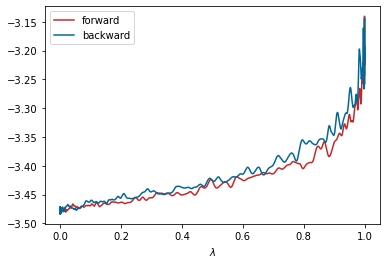

In [ ]:
plt.plot(al_sol.output.forward_lambda, al_sol.output.forward_energy_diff[0], 
         label="forward", color='#C62828')
plt.plot(al_sol.output.backward_lambda, al_sol.output.backward_energy_diff[0], 
         label="backward", color='#006899')
plt.legend()
plt.xlabel(r"$\lambda$");

### <font style="color:#B71C1C" face="Helvetica" > Free energy variation with temperature </font>

Now that we have calculated the free energy successfully, we can see how we get the variation of free energy with temperature. The easiest option is to run the calculations we saw above at multiple temperatures. We do at 600 K and 700 K.

In [ ]:
structure = pr.create.structure.ase.bulk('Al', cubic=True, a=4.1115).repeat(4)

In [ ]:
al_sol1 = pr.create.job.Calphy("Al_fcc_600", delete_aborted_job=True, delete_existing_job=True)
al_sol1.structure = structure
al_sol1.potential = "Al-atomicrex"
al_sol1.server.cores = 2
al_sol1.calc_free_energy(temperature=600, 
                     pressure=0, 
                     reference_phase="solid",
                     n_equilibration_steps=5000,
                     n_switching_steps=5000)
al_sol1.run()

The job Al_fcc_600 was saved and received the ID: 2


In [ ]:
structure = pr.create.structure.ase.bulk('Al', cubic=True, a=4.123).repeat(4)

In [ ]:
al_sol2 = pr.create.job.Calphy("Al_fcc_700", delete_aborted_job=True)
al_sol2.structure = structure
al_sol2.potential = "Al-atomicrex"
al_sol2.server.cores = 2
al_sol2.calc_free_energy(temperature=700, 
                     pressure=0, 
                     reference_phase="solid",
                     n_equilibration_steps=5000,
                     n_switching_steps=5000)
al_sol2.run()

The job Al_fcc_700 was saved and received the ID: 3


Compile the results and plot them

In [ ]:
temp = [500, 600, 700]
fes = [al_sol.output.energy_free, al_sol1.output.energy_free, al_sol2.output.energy_free]

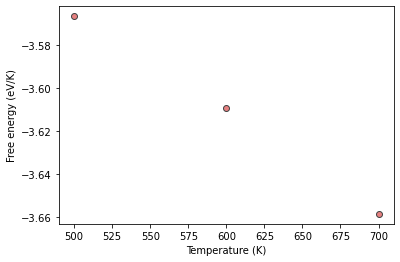

In [ ]:
plt.plot(temp, fes, 'o', label='fcc', color="#e58080", markeredgecolor="#424242")
plt.xlabel("Temperature (K)")
plt.ylabel("Free energy (eV/K)");

That works very well, but can we need three different calculations to arrive at the plot. Furthermore, in order to find the free energy at, for example, 650 K, we need to run another calculation. That is where, reversible scaling, the method discussed in the morning comes in.

### Reversible scaling

<img src="img/cimg6.png" width="600">

As discussed in the morning lecture, Gibb's free energy via reversible scaling at a constant pressure is given by,

$ G(N,P,T_f) = G(N,P,T_i) + \dfrac{3}{3}Nk_BT_f\ln{\dfrac{T_f}{T_i}} + \dfrac{T_f}{T_i}\Delta G $,

Therefore, $G(N,P,T_f)$ can be computed from $G(N,P,T_i)$ via the free energy difference $\Delta G$. 

Here, $\Delta G = \dfrac{1}{2}[W_{if}-W_{fi}$] --- (2)

The reversible work is related to the internal energy $U$ by,
$W = \int_{1}^{\lambda_f}<U> \,d\lambda$ --- (3)

Using MD $W$ can be computed as:
- equilibrate for time $t_{eq}$ in NPT ensemble
- switch $\lambda$ : $1->\dfrac{T_f}{T_i}$ over time $t_{sw}$
- calculate work $W_{if}$ from (3)
- equilibrate for time $t_{eq}$ in NPT ensemble
- switch $\lambda$ : $\dfrac{T_f}{T_i}->1$ over time $t_{sw}$
- calculate work $W_{fi}$ from (3).

In terms of actual calculation, nothing really changes. If a list of temperature is provided, pyiron realises that you want to perform a free energy calculation withing this range. Let's try this now.

In [ ]:
structure = pr.create.structure.ase.bulk('Al', cubic=True, a=4.09825).repeat(4)

In [ ]:
al_sol3 = pr.create.job.Calphy("Al_fcc_ts", delete_aborted_job=True)
al_sol3.structure = structure
al_sol3.potential = "Al-atomicrex"
al_sol3.server.cores = 2
al_sol3.calc_free_energy(temperature=[500, 700], 
                     pressure=0, 
                     reference_phase="solid",
                     n_equilibration_steps=5000,
                     n_switching_steps=5000)
al_sol3.run()

The job Al_fcc_ts was saved and received the ID: 4


Lets plot the results together with the free energy values we calculated earlier

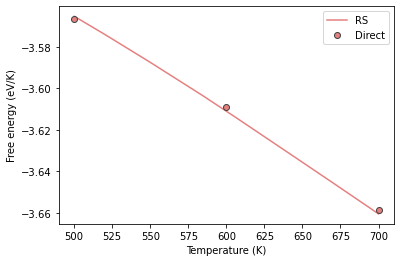

In [ ]:
plt.plot(al_sol3.output.temperature, al_sol3.output.energy_free, label='RS', color="#e58080", markeredgecolor="#424242")
plt.plot(temp, fes, 'o', label='Direct', color="#e58080", markeredgecolor="#424242")
plt.xlabel("Temperature (K)")
plt.ylabel("Free energy (eV/K)")
plt.legend();

We can see that there is excellent agreement between the direct and reversible scaling calculations. However for reversible scaling calculations, we just need to run a single calculation instead of different ones.

### <font style="color:#B71C1C" face="Helvetica" > Melting temperature of Al</font>

With the recipe we have, we can now go ahead and calculate the melting temperature of Al. This will actually give our first point on the phase diagram. First, the steps needed to find the melting temperature:

- Since the $T_m$ is 933 K, we can choose the range of 800-1100 K to calculate free energy
- Calculate free energy of FCC structure in this range
- Calculate free energy of liquid in this range.

By now, we have seen how to calculate the free energy of the FCC structure. This can be done rather quickly.

#### Free energy of solid

In [ ]:
structure = pr.create.structure.ase.bulk('Al', cubic=True, a=4.1362).repeat(4)

In [ ]:
al_fcc = pr.create.job.Calphy("Al_fcc_tm", delete_aborted_job=True)
al_fcc.structure = structure
al_fcc.potential = "Al-atomicrex"
al_fcc.server.cores = 2
al_fcc.calc_free_energy(temperature=[800, 1100], 
                     pressure=0, 
                     reference_phase="solid",
                     n_equilibration_steps=5000,
                     n_switching_steps=5000)
al_fcc.run()

The job Al_fcc_tm was saved and received the ID: 5


#### Free energy of liquid

Calculation of the free energy of liquid is as easy as changing the option `reference_phase` to `"liquid"`. That is all the change that is needed. Run the calculation..

In [ ]:
al_lqd = pr.create.job.Calphy("Al_lqd_tm", delete_aborted_job=True)
al_lqd.structure = structure
al_lqd.potential = "Al-atomicrex"
al_lqd.server.cores = 2
al_lqd.calc_free_energy(temperature=[800, 1100], 
                     pressure=0, 
                     reference_phase="liquid",
                     n_equilibration_steps=5000,
                     n_switching_steps=5000)
al_lqd.run()

The job Al_lqd_tm was saved and received the ID: 6


Before we actually look at the results, there are a couple of points to be discussed:

**How is the liquid prepared in this calculation?**

- Start from the given structure
- This structure is heated until it melts.
- Melting of the structure is automatically detected by calphy
- Once melted, it is equilibrated to the required temperature and pressure.

**What about the reference system for liquid?**

The reference system for the Liquid structure is also different. In this case, the Uhlenbeck-Ford system is used as the reference system for liquid.

The Uhlenbeck-Ford model is described by,

$$
E = - \epsilon \log(1-\exp(-r^2/\sigma^2))
$$

where,

$$
\epsilon = p k_B T
$$

$\epsilon$ and $\sigma$ are energy and length scales, respectively.

It is purely repulsive liquid model which does not undergo any phase transformations.

Now that we have covered these details, we can go ahead a look at the results.

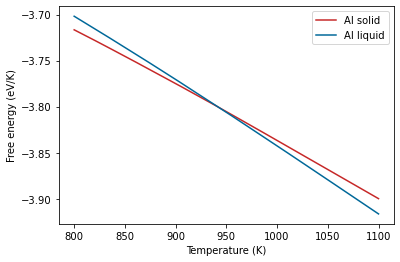

In [ ]:
plt.plot(al_fcc.output.temperature, al_fcc.output.energy_free,
        label="Al solid", color='#C62828')
plt.plot(al_lqd.output.temperature, al_lqd.output.energy_free,
        label="Al liquid", color='#006899')
plt.xlabel("Temperature (K)")
plt.ylabel("Free energy (eV/K)")
plt.legend();

The melting temperature is defined as the temperature at which the free energy difference between the solid and liquid phases is zero. We can also plot the free energy difference directly.

In [ ]:
fediff = al_fcc.output.energy_free - al_lqd.output.energy_free

Find where the value is zero and get the corresponding temperature

In [ ]:
arg = np.argsort(np.abs(fediff))[0]
tm = al_fcc.output.temperature[arg]
tm

942.9916874292612

The calculated melting temperature is shown above.

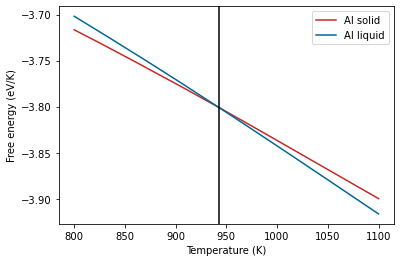

In [ ]:
plt.plot(al_fcc.output.temperature, al_fcc.output.energy_free,
        label="Al solid", color='#C62828')
plt.plot(al_lqd.output.temperature, al_lqd.output.energy_free,
        label="Al liquid", color='#006899')
plt.axvline(tm, color="black")
plt.xlabel("Temperature (K)")
plt.ylabel("Free energy (eV/K)")
plt.legend();

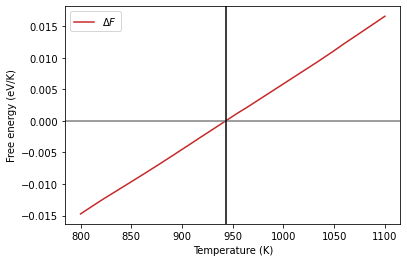

In [ ]:
plt.plot(al_fcc.output.temperature, fediff,
        label=r"$\Delta F$", color='#C62828')
plt.axhline(0, color="gray")
plt.axvline(tm, color="black")
plt.xlabel("Temperature (K)")
plt.ylabel("Free energy (eV/K)")
plt.legend();

### <font style="color:#B71C1C" face="Helvetica" > Comparison of melting temperature methods </font>

<img src="img/tm_methods.png" width="900">

### Further reading

- [Menon, Sarath, Yury Lysogorskiy, Jutta Rogal, and Ralf Drautz. “Automated Free-Energy Calculation from Atomistic Simulations.” Physical Review Materials 5, no. 10 (October 11, 2021): 103801.](https://doi.org/10.1103/PhysRevMaterials.5.103801).
- [Freitas, Rodrigo, Mark Asta, and Maurice de Koning. “Nonequilibrium Free-Energy Calculation of Solids Using LAMMPS.” Computational Materials Science 112 (February 2016): 333–41.](https://doi.org/10.1016/j.commatsci.2015.10.050).
- [Paula Leite, Rodolfo, and Maurice de Koning. “Nonequilibrium Free-Energy Calculations of Fluids Using LAMMPS.” Computational Materials Science 159 (March 2019): 316–26.](https://doi.org/10.1016/j.commatsci.2018.12.029).
- [Koning, Maurice de, A. Antonelli, and Sidney Yip. “Optimized Free-Energy Evaluation Using a Single Reversible-Scaling Simulation.” Physical Review Letters 83, no. 20 (November 15, 1999): 3973–77.](https://doi.org/10.1103/PhysRevLett.83.3973).
- [Paula Leite, Rodolfo, Rodrigo Freitas, Rodolfo Azevedo, and Maurice de Koning. “The Uhlenbeck-Ford Model: Exact Virial Coefficients and Application as a Reference System in Fluid-Phase Free-Energy Calculations.” The Journal of Chemical Physics 145, no. 19 (November 21, 2016): 194101.](https://doi.org/10.1063/1.4967775).

